In [14]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

In [2]:
conn = sqlite3.connect("database.db")

We use left joins to create a dataframe for all records, as specified in the instructions. We'll drop invalid records later.

In [3]:
query = ("SELECT x, y, z, color_id, color_name "
         "FROM data d LEFT JOIN connection c ON d.connection_id = c.id "
         "LEFT JOIN additional_data ad ON c.name = ad.color_name")
    
df_raw = pd.read_sql_query(query, conn)

First, we drop data with missing values (either null values from the database or null values resulting from unmatched records in left joins)

In [4]:
df_raw.dropna(inplace=True)

We try to convert the data to correct types. It turns out that we removed any invalid types in our previous step already, so we can go ahead and convert the rest without any errors.   

In [5]:
df = df_raw.astype({"x": float, "y": float, "z": float,  "color_id": int})
df.dtypes

x             float64
y             float64
z             float64
color_id        int64
color_name     object
dtype: object

We rename the columns and list unique colors as specified in the instructions

In [6]:
df.rename(columns={"color_name": "color"}, inplace=True)
df.color.unique().tolist()

['green', 'orange', 'yellow', 'red', 'black', 'blue']

In [7]:
df = df.query('z == 100')

We define 'avg' as average red points’ position. We then define 'sigma' as standard deviation of distance to 'avg'.

In [8]:
avg = df.query('color == "red"')[['x', 'y']].mean(axis=0)
sigma = df.query('color == "red"').apply(lambda point: np.linalg.norm(point.loc[['x','y']] - avg) , axis=1).std()

We now drop red points that have a distance from 'avg' greater than 'sigma'

In [9]:
df = df.loc[(df['color'] != 'red') | ((df[['x','y']] - avg).apply(np.linalg.norm, axis=1) <= sigma)]

In [10]:
df.reset_index(drop=True, inplace=True)

In [11]:
df[['x','y','color']].to_hdf('dataset.h5', key='ns1', mode='w')

In [12]:
ns1 = pd.read_hdf('dataset.h5', 'ns1')

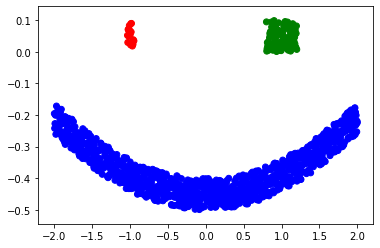

In [15]:
scatter = plt.scatter(df.x, df.y, c=df.color)
plt.savefig('scatter.png')